# Install dependencies and import libraries


In [ ]:
!pip install -U "ibis-framework[duckdb]"
!pip install gdown
!pip install sdv
!pip install optuna

In [ ]:
import pandas as pd
import gdown
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, matthews_corrcoef

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
import gdown
import ibis
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import Metadata
from tqdm import tqdm
import shutil
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import optuna
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
import math


# Download Data

Actual code for all data but commented out

In [ ]:
# if not os.path.exists("student-performance/test.csv"):
#     !gdown --folder https://drive.google.com/drive/folders/1d1_DVmZkIJsNPSbZG6gwzQDx33zhyWo1?usp=sharing -O student-performance
# else:
#     print("Data already downloaded.")

In [ ]:
# # Create the folder if it doesn't exist
# output_folder = "student-performance"
# os.makedirs(output_folder, exist_ok=True)

# # file_id = "1u4edCFSJ2uwikVm4f_2RTEDqr1aPgEAL"
# # gdrive_url = f"https://drive.google.com/uc?id={file_id}"

# # Set the output path to be inside the student-performance folder
# output_file_train = os.path.join(output_folder, "train.csv")
# output_file_test = os.path.join(output_folder, "test.csv")
# output_file_validation = os.path.join(output_folder, "validation.csv")

# # Download the file
# gdown.download(gdrive_url, output_file_train, quiet=False)
# gdown.download(gdrive_url, output_file_test, quiet=False)
# gdown.download(gdrive_url, output_file_validation, quiet=False)


In [ ]:
# Create the folder
output_folder = "student-performance"
os.makedirs(output_folder, exist_ok=True)

file_id = "1u4edCFSJ2uwikVm4f_2RTEDqr1aPgEAL"
gdrive_url = f"https://drive.google.com/uc?id={file_id}"

# Set the output path to be inside the student-performance folder
output_file_train = os.path.join(output_folder, "train.csv")
output_file_test = os.path.join(output_folder, "test.csv")
output_file_validation = os.path.join(output_folder, "validation.csv")

# Download the file
gdown.download(gdrive_url, output_file_train, quiet=False)
gdown.download(gdrive_url, output_file_test, quiet=False)
gdown.download(gdrive_url, output_file_validation, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1u4edCFSJ2uwikVm4f_2RTEDqr1aPgEAL
To: /content/student-performance/train.csv
100%|██████████| 1.65M/1.65M [00:00<00:00, 39.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1u4edCFSJ2uwikVm4f_2RTEDqr1aPgEAL
To: /content/student-performance/test.csv
100%|██████████| 1.65M/1.65M [00:00<00:00, 47.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1u4edCFSJ2uwikVm4f_2RTEDqr1aPgEAL
To: /content/student-performance/validation.csv
100%|██████████| 1.65M/1.65M [00:00<00:00, 59.2MB/s]


'student-performance/validation.csv'

In [ ]:
# Reset the DuckDB database
if os.path.exists("student_performance.duckdb"):
    os.remove("student_performance.duckdb")

con = ibis.duckdb.connect("student_performance.duckdb")

# Register CSVs as DuckDB tables
test = con.read_csv("student-performance/test.csv", table_name="test")
train = con.read_csv("student-performance/train.csv", table_name="train")
validation = con.read_csv("student-performance/validation.csv", table_name="validation")

# Synthesize Data

In [ ]:
# Combine separated datasets into one dataset
all_data_expr = train.union(test).union(validation)
sample_df = all_data_expr.to_pandas()

In [ ]:
pd.set_option('display.max_columns', None)
sample_df.head(20)

,Age,Grade,Gender,Race,SES_Quartile,ParentalEducation,SchoolType,Locale,TestScore_Math,TestScore_Reading,TestScore_Science,GPA,AttendanceRate,StudyHours,InternetAccess,Extracurricular,PartTimeJob,ParentSupport,Romantic,FreeTime,GoOut
0,17,12,Female,White,3,HS,Public,Suburban,70.258235,79.665185,80.824230,2.743879,0.906809,1.089243,1,1,0,0,0,2,2
1,18,12,Female,White,2,HS,Public,Suburban,67.876546,59.611505,70.920341,2.587700,0.843739,0.879911,1,1,0,1,0,5,2
2,16,11,Female,White,2,HS,Public,City,62.070623,70.577443,60.624018,2.426294,0.850923,1.003442,1,1,0,1,1,5,1
3,14,9,Female,White,4,Bachelors+,Public,Town,79.909312,82.924450,85.585315,3.558240,0.946786,1.814810,1,1,0,1,0,4,2
4,16,11,Female,Two-or-more,4,SomeCollege,Public,Rural,90.562294,95.352336,88.928161,3.896884,0.988036,1.157241,1,1,0,0,0,3,4
5,14,9,Female,Hispanic,1,SomeCollege,Public,Suburban,74.323709,77.639839,72.725503,2.728882,0.875276,0.800096,1,1,0,0,0,2,2
6,16,11,Female,Black,1,SomeCollege,Private,Suburban,62.068741,71.367186,64.477760,3.058144,0.880969,0.785428,1,0,0,1,0,3,2
7,18,12,Female,White,1,HS,Public,Suburban,73.280029,62.164448,80.004418,2.878577,0.913663,1.533874,1,1,1,0,0,4,1
8,18,12,Female,Hispanic,1,<HS,Public,Suburban,60.588339,74.419737,75.956630,2.841019,0.849471,0.985229,1,1,0,0,1,2,4
9,16,11,Female,White,3,HS,Public,Suburban,73.169137,80.831831,72.522671,2.856098,0.914255,1.088166,1,0,0,0,0,3,3


In [ ]:
sample_df.columns

Index(['Age', 'Grade', 'Gender', 'Race', 'SES_Quartile', 'ParentalEducation',
       'SchoolType', 'Locale', 'TestScore_Math', 'TestScore_Reading',
       'TestScore_Science', 'GPA', 'AttendanceRate', 'StudyHours',
       'InternetAccess', 'Extracurricular', 'PartTimeJob', 'ParentSupport',
       'Romantic', 'FreeTime', 'GoOut'],
      dtype='object')

In [ ]:
# Load or detect metadata
if os.path.exists("metadata.json"):
    metadata = Metadata.load_from_json("metadata.json")
else:
    metadata = Metadata.detect_from_dataframe(sample_df)
    metadata.save_to_json("metadata.json")

# Load or fit synthesizer
if os.path.exists("GaussianCopulaSynthesizer.pkl"):
    synthesizer = GaussianCopulaSynthesizer.load("GaussianCopulaSynthesizer.pkl")
else:
    synthesizer = GaussianCopulaSynthesizer(metadata)
    synthesizer.fit(sample_df)
    synthesizer.save("GaussianCopulaSynthesizer.pkl")

In [ ]:
# # Generate 50M synthetic rows in 1M-row chunks and write directly to DuckDB
# total_rows = 50_000
# chunk_size = 1_000
# num_chunks = total_rows // chunk_size

# # Create DuckDB connection
# if os.path.exists("student_performance.duckdb"):
#     os.remove("student_performance.duckdb")
# con = ibis.duckdb.connect("student_performance.duckdb")

# for i in tqdm(range(num_chunks)):
#     chunk_df = synthesizer.sample(chunk_size)

#     if i == 0:
#         # First chunk: create table
#         con.create_table("synthetic", chunk_df)
#     else:
#         # Subsequent chunks: append to table
#         con.create_table("chunk_df", chunk_df, overwrite=True)
#         con.raw_sql("INSERT INTO synthetic SELECT * FROM chunk_df")


In [ ]:
db_path = "student_performance.duckdb"

# Remove file
if os.path.exists(db_path):
    os.remove(db_path)
    print("DuckDB file deleted.")
else:
    print("No DuckDB file found.")

# Force reinitialization of the DuckDB connection
con = ibis.duckdb.connect(db_path)
print("Reconnected to fresh DuckDB database.")


for table in con.list_tables():
    con.drop_table(table)
    print(f"Dropped table: {table}")


No DuckDB file found.
Reconnected to fresh DuckDB database.
Dropped table: academic_performance
Dropped table: extracurriculars
Dropped table: genders
Dropped table: parental_education
Dropped table: races
Dropped table: schools
Dropped table: students


In [ ]:
TOTAL_ROWS = 50_000
BATCH_SIZE = 50_000
N_BATCHES  = math.ceil(TOTAL_ROWS / BATCH_SIZE)

def add_gpa_category(df):
    bins   = [0, 2.5, 3.0, 3.5, 4.1]
    labels = ["Low", "Mid-Low", "Mid-High", "High"]
    df["Gpa_Category"] = pd.cut(df["Gpa"], bins=bins, labels=labels, include_lowest=True)
    return df

def normalize_dim(df, colname, table_name, label_col, fk_name, con):
    values = df[colname].dropna().unique()
    id_map = {val: idx + 1 for idx, val in enumerate(values)}
    dim_df = pd.DataFrame({
        "Id":           list(id_map.values()),
        label_col:      list(id_map.keys())
    })
    # only create the dim table once
    if table_name not in con.list_tables():
        con.create_table(table_name, dim_df)

    # map into table
    df[fk_name] = df[colname].map(id_map)
    df.drop(columns=[colname], inplace=True)
    return df



def normalize_schools(df, con):
    school_df = (
        df[["Schooltype", "Locale"]]
        .drop_duplicates()
        .reset_index(drop=True)
        .copy()
    )
    school_df["Id"] = school_df.index + 1

    # only create once
    if "schools" not in con.list_tables():
        school_dim = school_df.rename(columns={
            "Schooltype": "School_Type",
        })
        con.create_table("schools", school_dim)

    # merge back
    df = df.merge(school_df, on=["Schooltype", "Locale"], how="left")
    df.drop(columns=["Schooltype", "Locale"], inplace=True)
    df.rename(columns={"Id": "School_Id"}, inplace=True)
    return df

# Initialize Student_Id counter
next_student_id = 1

# Stream in BATCH_SIZE chunks
for batch_idx in range(N_BATCHES):
    # sample & clean column names
    df = synthesizer.sample(BATCH_SIZE)
    df.columns = df.columns.str.strip().str.title()

    # assign Student_Id
    df["Student_Id"] = range(next_student_id, next_student_id + len(df))
    next_student_id += len(df)

    # apply normalization
    df = add_gpa_category(df)
    df = normalize_dim(df, "Gender",             "genders",             "Gender_Label",            "Gender_Id",             con)
    df = normalize_dim(df, "Race",               "races",               "Race_Label",              "Race_Id",               con)
    df = normalize_dim(df, "Parentaleducation",  "parental_education",  "Education_Level",         "Parental_Education_Id", con)
    df = normalize_schools(df, con)

    df = df.rename(columns={
        "Testscore_Math":    "Test_Score_Math",
        "Testscore_Reading": "Test_Score_Reading",
        "Testscore_Science": "Test_Score_Science",
        "Attendancerate":    "Attendance_Rate",
        "Studyhours":        "Study_Hours"
    })

    # select columns & write out
    student_cols = [
        "Student_Id", "Age", "Grade", "Gender_Id", "Race_Id", "Ses_Quartile",
        "Parental_Education_Id", "School_Id", "Internetaccess",
        "Parttimejob", "Parentsupport", "Romantic", "Freetime", "Goout"
    ]
    perf_cols = [
        "Student_Id", "Test_Score_Math", "Test_Score_Reading",
        "Test_Score_Science", "Gpa", "Attendance_Rate", "Study_Hours"
    ]
    extra_df = df[["Student_Id", "Extracurricular"]].copy()
    extra_df.rename(columns={"Extracurricular": "Activity_Name"}, inplace=True)
    extra_df["Id"] = range(1, len(extra_df) + 1)
    extra_df = extra_df[["Id", "Student_Id", "Activity_Name"]]

    if batch_idx == 0:
        con.create_table("students",              df[student_cols])
        con.create_table("academic_performance",  df[perf_cols])
        con.create_table("extracurriculars",      extra_df)
    else:
        con.insert("students",             df[student_cols])
        con.insert("academic_performance", df[perf_cols])
        con.insert("extracurriculars",     extra_df)

    # free up memory immediately
    del df, extra_df

print("Full ERD normalization complete (streamed in batches).")


Full ERD normalization complete (streamed in batches).


In [ ]:
# # df = synthesizer.sample(50_000)
# df = synthesizer.sample(50_000_000)
# df.columns = df.columns.str.strip().str.title()
# df["Student_Id"] = range(1, len(df) + 1)

# def add_gpa_category(df):
#     bins = [0, 2.5, 3.0, 3.5, 4.1]
#     labels = ["Low", "Mid-Low", "Mid-High", "High"]
#     df["Gpa_Category"] = pd.cut(df["Gpa"], bins=bins, labels=labels, include_lowest=True)
#     return df

# def normalize_dim(df, colname, table_name, label_col, fk_name, con):
#     values = df[colname].dropna().unique()
#     id_map = {val: idx + 1 for idx, val in enumerate(values)}
#     dim_df = pd.DataFrame({
#         "Id": list(id_map.values()),
#         label_col: list(id_map.keys())
#     })
#     con.create_table(table_name, dim_df)
#     df[fk_name] = df[colname].map(id_map)
#     df.drop(columns=[colname], inplace=True)
#     return df

# def normalize_schools(df, con):
#     school_df = df[["Schooltype", "Locale"]].drop_duplicates().reset_index(drop=True).copy()
#     school_df["Id"] = school_df.index + 1
#     df = df.merge(school_df, on=["Schooltype", "Locale"], how="left")
#     df.drop(columns=["Schooltype", "Locale"], inplace=True)
#     df.rename(columns={"Id": "School_Id"}, inplace=True)

#     school_df.rename(columns={"Schooltype": "School_Type", "Locale": "Locale"}, inplace=True)
#     con.create_table("schools", school_df.rename(columns={"Id": "Id"}))
#     return df

# # Apply Normalization
# df = add_gpa_category(df)
# df = normalize_dim(df, "Gender", "genders", "Gender_Label", "Gender_Id", con)
# df = normalize_dim(df, "Race", "races", "Race_Label", "Race_Id", con)
# df = normalize_dim(df, "Parentaleducation", "parental_education", "Education_Level", "Parental_Education_Id", con)
# df = normalize_schools(df, con)

# df = df.rename(columns={
#     "Testscore_Math": "Test_Score_Math",
#     "Testscore_Reading": "Test_Score_Reading",
#     "Testscore_Science": "Test_Score_Science",
#     "Attendancerate": "Attendance_Rate",
#     "Studyhours": "Study_Hours"
# })

# student_cols = [
#     "Student_Id", "Age", "Grade", "Gender_Id", "Race_Id", "Ses_Quartile",
#     "Parental_Education_Id", "School_Id", "Internetaccess",
#     "Parttimejob", "Parentsupport", "Romantic", "Freetime", "Goout"
# ]
# con.create_table("students", df[student_cols])

# perf_cols = [
#     "Student_Id", "Test_Score_Math", "Test_Score_Reading",
#     "Test_Score_Science", "Gpa", "Attendance_Rate", "Study_Hours"
# ]
# con.create_table("academic_performance", df[perf_cols])

# extra_df = df[["Student_Id", "Extracurricular"]].copy()
# extra_df.rename(columns={"Extracurricular": "Activity_Name"}, inplace=True)
# extra_df["Id"] = range(1, len(extra_df) + 1)
# extra_df = extra_df[["Id", "Student_Id", "Activity_Name"]]
# con.create_table("extracurriculars", extra_df)

# print("Full ERD normalization complete.")

In [ ]:
print(con.tables)

Tables
------
- academic_performance
- extracurriculars
- genders
- parental_education
- races
- schools
- students


In [ ]:
# List all tables
tables = con.list_tables()
print("Tables in database:")
for t in tables:
    print(f"  - {t}")

print("\nTable schemas:\n")

# Show schema and preview rows for each table
for table in tables:
    expr = con.table(table)
    print(f"Schema for `{table}`:")
    print(expr.schema())
    print("\nSample rows from `{table}`:")
    display(expr.limit(5).to_pandas())
    print("-" * 60)


Tables in database:
  - academic_performance
  - extracurriculars
  - genders
  - parental_education
  - races
  - schools
  - students

Table schemas:

Schema for `academic_performance`:
ibis.Schema {
  Student_Id          int64
  Test_Score_Math     float64
  Test_Score_Reading  float64
  Test_Score_Science  float64
  Gpa                 float64
  Attendance_Rate     float64
  Study_Hours         float64
}

Sample rows from `{table}`:


,Student_Id,Test_Score_Math,Test_Score_Reading,Test_Score_Science,Gpa,Attendance_Rate,Study_Hours
0,1,63.333302,67.921441,67.027222,2.753645,0.839815,0.706309
1,2,65.659107,72.992844,73.691328,3.181524,0.913288,0.772679
2,3,85.869364,76.965290,73.775565,2.721903,0.914597,1.172886
3,4,53.844116,55.258137,66.227299,2.107865,0.838197,0.702355
4,5,96.975515,80.471101,91.026985,3.243575,0.975748,1.217014


------------------------------------------------------------
Schema for `extracurriculars`:
ibis.Schema {
  Id             int64
  Student_Id     int64
  Activity_Name  int64
}

Sample rows from `{table}`:


,Id,Student_Id,Activity_Name
0,1,1,1
1,2,2,0
2,3,3,1
3,4,4,0
4,5,5,1


------------------------------------------------------------
Schema for `genders`:
ibis.Schema {
  Id            int64
  Gender_Label  string
}

Sample rows from `{table}`:


,Id,Gender_Label
0,1,Female
1,2,Male


------------------------------------------------------------
Schema for `parental_education`:
ibis.Schema {
  Id               int64
  Education_Level  string
}

Sample rows from `{table}`:


,Id,Education_Level
0,1,SomeCollege
1,2,HS
2,3,Bachelors+
3,4,<HS


------------------------------------------------------------
Schema for `races`:
ibis.Schema {
  Id          int64
  Race_Label  string
}

Sample rows from `{table}`:


,Id,Race_Label
0,1,White
1,2,Hispanic
2,3,Two-or-more
3,4,Black
4,5,Asian


------------------------------------------------------------
Schema for `schools`:
ibis.Schema {
  School_Type  string
  Locale       string
  Id           int64
}

Sample rows from `{table}`:


,School_Type,Locale,Id
0,Public,Suburban,1
1,Public,City,2
2,Private,Suburban,3
3,Public,Town,4
4,Public,Rural,5


------------------------------------------------------------
Schema for `students`:
ibis.Schema {
  Student_Id             int64
  Age                    int64
  Grade                  int64
  Gender_Id              int64
  Race_Id                int64
  Ses_Quartile           int64
  Parental_Education_Id  int64
  School_Id              int64
  Internetaccess         int64
  Parttimejob            int64
  Parentsupport          int64
  Romantic               int64
  Freetime               int64
  Goout                  int64
}

Sample rows from `{table}`:


,Student_Id,Age,Grade,Gender_Id,Race_Id,Ses_Quartile,Parental_Education_Id,School_Id,Internetaccess,Parttimejob,Parentsupport,Romantic,Freetime,Goout
0,1,18,12,1,1,4,1,1,1,0,0,0,2,1
1,2,17,12,2,2,1,2,1,1,0,1,1,2,2
2,3,17,12,2,2,4,3,2,1,0,0,0,4,1
3,4,17,12,1,1,3,1,3,1,0,0,0,2,2
4,5,16,12,2,2,1,1,1,1,0,0,0,4,1


------------------------------------------------------------


# Data Cleaning

In [ ]:
# Connect to DuckDB
con = ibis.duckdb.connect("student_performance.duckdb")

# List all tables
tables = con.list_tables()
print("Tables in database:", tables)

# Print out each table’s schema
for t in tables:
    print(f"\nSchema for `{t}`:")
    print(con.table(t).schema())

# Peek at the first 5 rows of each table
for t in tables:
    print(f"\nFirst 5 rows of `{t}`:")
    print(con.table(t).limit(5).execute())


Tables in database: ['academic_performance', 'extracurriculars', 'genders', 'parental_education', 'races', 'schools', 'students']

Schema for `academic_performance`:
ibis.Schema {
  Student_Id          int64
  Test_Score_Math     float64
  Test_Score_Reading  float64
  Test_Score_Science  float64
  Gpa                 float64
  Attendance_Rate     float64
  Study_Hours         float64
}

Schema for `extracurriculars`:
ibis.Schema {
  Id             int64
  Student_Id     int64
  Activity_Name  int64
}

Schema for `genders`:
ibis.Schema {
  Id            int64
  Gender_Label  string
}

Schema for `parental_education`:
ibis.Schema {
  Id               int64
  Education_Level  string
}

Schema for `races`:
ibis.Schema {
  Id          int64
  Race_Label  string
}

Schema for `schools`:
ibis.Schema {
  School_Type  string
  Locale       string
  Id           int64
}

Schema for `students`:
ibis.Schema {
  Student_Id             int64
  Age                    int64
  Grade                  i

In [ ]:
con       = ibis.duckdb.connect("student_performance.duckdb")
dbapi_con = con.con

# full‐join SQL exactly as before
sql = """
SELECT
  s.Student_Id,
  s.Age,
  s.Grade,
  s.Ses_Quartile,
  s.Internetaccess   AS InternetAccess,
  s.Parttimejob      AS PartTimeJob,
  s.Parentsupport    AS ParentSupport,
  s.Romantic,
  s.Freetime         AS FreeTime,
  s.Goout            AS GoOut,
  g.Gender_Label     AS Gender,
  r.Race_Label       AS Race,
  pe.Education_Level AS ParentalEducation,
  sc.School_Type     AS SchoolType,
  sc.Locale          AS Locale,
  p.Test_Score_Math     AS TestScore_Math,
  p.Test_Score_Reading  AS TestScore_Reading,
  p.Test_Score_Science  AS TestScore_Science,
  p.Gpa                 AS GPA,
  p.Attendance_Rate     AS AttendanceRate,
  p.Study_Hours         AS StudyHours,
  e.Activity_Name       AS Extracurricular
FROM students    AS s
JOIN genders             AS g  ON s.Gender_Id             = g.Id
JOIN races               AS r  ON s.Race_Id               = r.Id
JOIN parental_education  AS pe ON s.Parental_Education_Id = pe.Id
JOIN schools             AS sc ON s.School_Id             = sc.Id
JOIN academic_performance AS p ON s.Student_Id            = p.Student_Id
JOIN extracurriculars     AS e ON s.Student_Id            = e.Student_Id
ORDER BY s.Student_Id
"""

# 3) Stream it in pandas‐side, chunk by chunk
chunksize = 50_000
frames = []

for chunk in pd.read_sql_query(sql, dbapi_con, chunksize=chunksize):
    # Convert strings to categoricals
    for col in ["Gender", "Race", "ParentalEducation",
                "SchoolType", "Locale", "Extracurricular"]:
        chunk[col] = chunk[col].astype("category")

    # Downcast integer columns
    int_cols = ["Student_Id", "Age", "Grade",
                "Ses_Quartile", "InternetAccess",
                "PartTimeJob", "ParentSupport"]
    for col in int_cols:
        chunk[col] = pd.to_numeric(chunk[col], downcast="integer")

    # 4 Downcast floats
    float_cols = ["TestScore_Math", "TestScore_Reading",
                  "TestScore_Science", "GPA",
                  "AttendanceRate", "StudyHours"]
    for col in float_cols:
        chunk[col] = pd.to_numeric(chunk[col], downcast="float")

    frames.append(chunk)

# Concatenate once
df_full = pd.concat(frames, ignore_index=True)
del frames  # free intermediate list

print(df_full.info(memory_usage="deep"))
print(df_full.shape)
df_full.head()

/tmp/ipython-input-1983622108.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  for chunk in pd.read_sql_query(sql, dbapi_con, chunksize=chunksize):


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Student_Id         50000 non-null  int32   
 1   Age                50000 non-null  int8    
 2   Grade              50000 non-null  int8    
 3   Ses_Quartile       50000 non-null  int8    
 4   InternetAccess     50000 non-null  int8    
 5   PartTimeJob        50000 non-null  int8    
 6   ParentSupport      50000 non-null  int8    
 7   Romantic           50000 non-null  int64   
 8   FreeTime           50000 non-null  int64   
 9   GoOut              50000 non-null  int64   
 10  Gender             50000 non-null  category
 11  Race               50000 non-null  category
 12  ParentalEducation  50000 non-null  category
 13  SchoolType         50000 non-null  category
 14  Locale             50000 non-null  category
 15  TestScore_Math     50000 non-null  float32 
 16  Test

,Student_Id,Age,Grade,Ses_Quartile,InternetAccess,PartTimeJob,ParentSupport,Romantic,FreeTime,GoOut,Gender,Race,ParentalEducation,SchoolType,Locale,TestScore_Math,TestScore_Reading,TestScore_Science,GPA,AttendanceRate,StudyHours,Extracurricular
0,1,18,12,4,1,0,0,0,2,1,Female,White,SomeCollege,Public,Suburban,63.333302,67.921440,67.027222,2.753645,0.839815,0.706309,1
1,2,17,12,1,1,0,1,1,2,2,Male,Hispanic,HS,Public,Suburban,65.659103,72.992844,73.691330,3.181524,0.913288,0.772679,0
2,3,17,12,4,1,0,0,0,4,1,Male,Hispanic,Bachelors+,Public,City,85.869362,76.965286,73.775566,2.721903,0.914597,1.172886,1
3,4,17,12,3,1,0,0,0,2,2,Female,White,SomeCollege,Private,Suburban,53.844116,55.258137,66.227303,2.107865,0.838197,0.702355,0
4,5,16,12,1,1,0,0,0,4,1,Male,Hispanic,SomeCollege,Public,Suburban,96.975517,80.471100,91.026985,3.243575,0.975748,1.217014,1


In [ ]:
# keep only columns without “id” in their name
df_clean = df_full.loc[:, ~df_full.columns.str.lower().str.contains("id")]

print(df_clean.columns.tolist())
df_clean.head()


['Age', 'Grade', 'Ses_Quartile', 'InternetAccess', 'PartTimeJob', 'ParentSupport', 'Romantic', 'FreeTime', 'GoOut', 'Gender', 'Race', 'ParentalEducation', 'SchoolType', 'Locale', 'TestScore_Math', 'TestScore_Reading', 'TestScore_Science', 'GPA', 'AttendanceRate', 'StudyHours', 'Extracurricular']


,Age,Grade,Ses_Quartile,InternetAccess,PartTimeJob,ParentSupport,Romantic,FreeTime,GoOut,Gender,Race,ParentalEducation,SchoolType,Locale,TestScore_Math,TestScore_Reading,TestScore_Science,GPA,AttendanceRate,StudyHours,Extracurricular
0,18,12,4,1,0,0,0,2,1,Female,White,SomeCollege,Public,Suburban,63.333302,67.921440,67.027222,2.753645,0.839815,0.706309,1
1,17,12,1,1,0,1,1,2,2,Male,Hispanic,HS,Public,Suburban,65.659103,72.992844,73.691330,3.181524,0.913288,0.772679,0
2,17,12,4,1,0,0,0,4,1,Male,Hispanic,Bachelors+,Public,City,85.869362,76.965286,73.775566,2.721903,0.914597,1.172886,1
3,17,12,3,1,0,0,0,2,2,Female,White,SomeCollege,Private,Suburban,53.844116,55.258137,66.227303,2.107865,0.838197,0.702355,0
4,16,12,1,1,0,0,0,4,1,Male,Hispanic,SomeCollege,Public,Suburban,96.975517,80.471100,91.026985,3.243575,0.975748,1.217014,1


In [ ]:
df = df_clean

In [ ]:
# # Connect to DuckDB database
# con = ibis.duckdb.connect("student_performance.duckdb")

# # Read from the synthetic table (already created)
# synthetic_table = con.table("synthetic")

# # Convert to Pandas DataFrame
# df = synthetic_table.execute()
# print(df.head())

In [ ]:
# Basic info
print("DataFrame Info:")
df.info()

# Descriptive statistics
print("\nDescriptive Statistics:")
print(df.describe(include="all"))

# Value counts for all categorical/object columns
print("\nValue Counts:")
for col in df.select_dtypes(include="object").columns:
    print(f"\n{col} value counts:")
    print(df[col].value_counts())

# Missing data analysis
print("\nMissing Data Analysis:")
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    "Missing Values": missing,
    "Percentage": missing_percent
})
print(missing_df[missing_df["Missing Values"] > 0])

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Age                50000 non-null  int8    
 1   Grade              50000 non-null  int8    
 2   Ses_Quartile       50000 non-null  int8    
 3   InternetAccess     50000 non-null  int8    
 4   PartTimeJob        50000 non-null  int8    
 5   ParentSupport      50000 non-null  int8    
 6   Romantic           50000 non-null  int64   
 7   FreeTime           50000 non-null  int64   
 8   GoOut              50000 non-null  int64   
 9   Gender             50000 non-null  category
 10  Race               50000 non-null  category
 11  ParentalEducation  50000 non-null  category
 12  SchoolType         50000 non-null  category
 13  Locale             50000 non-null  category
 14  TestScore_Math     50000 non-null  float32 
 15  TestScore_Reading  50000 non-null  fl

In [ ]:
# Drop rows with NaN values and duplicates
df = df.dropna().drop_duplicates()

# Drop columns with too many categories
threshold = 50
drop_cols = [col for col in df.select_dtypes(include='object').columns if df[col].nunique() > threshold]
df = df.drop(columns=drop_cols)

# Convert GPA to bins with labels
bins = [0, 2.5, 3.0, 3.5, 4.01]
labels = [
    "Low (0.00–2.49)",
    "Mid-Low (2.50–2.99)",
    "Mid-High (3.00–3.49)",
    "High (3.50–4.00)"
]
df["GPA_bins"] = pd.cut(
    df["GPA"], bins=bins, labels=labels, include_lowest=True, right=False
)

print(df["GPA_bins"].value_counts())

GPA_bins
Mid-High (3.00–3.49)    18046
Mid-Low (2.50–2.99)     17364
Low (0.00–2.49)          7467
High (3.50–4.00)         7123
Name: count, dtype: int64


# EDA

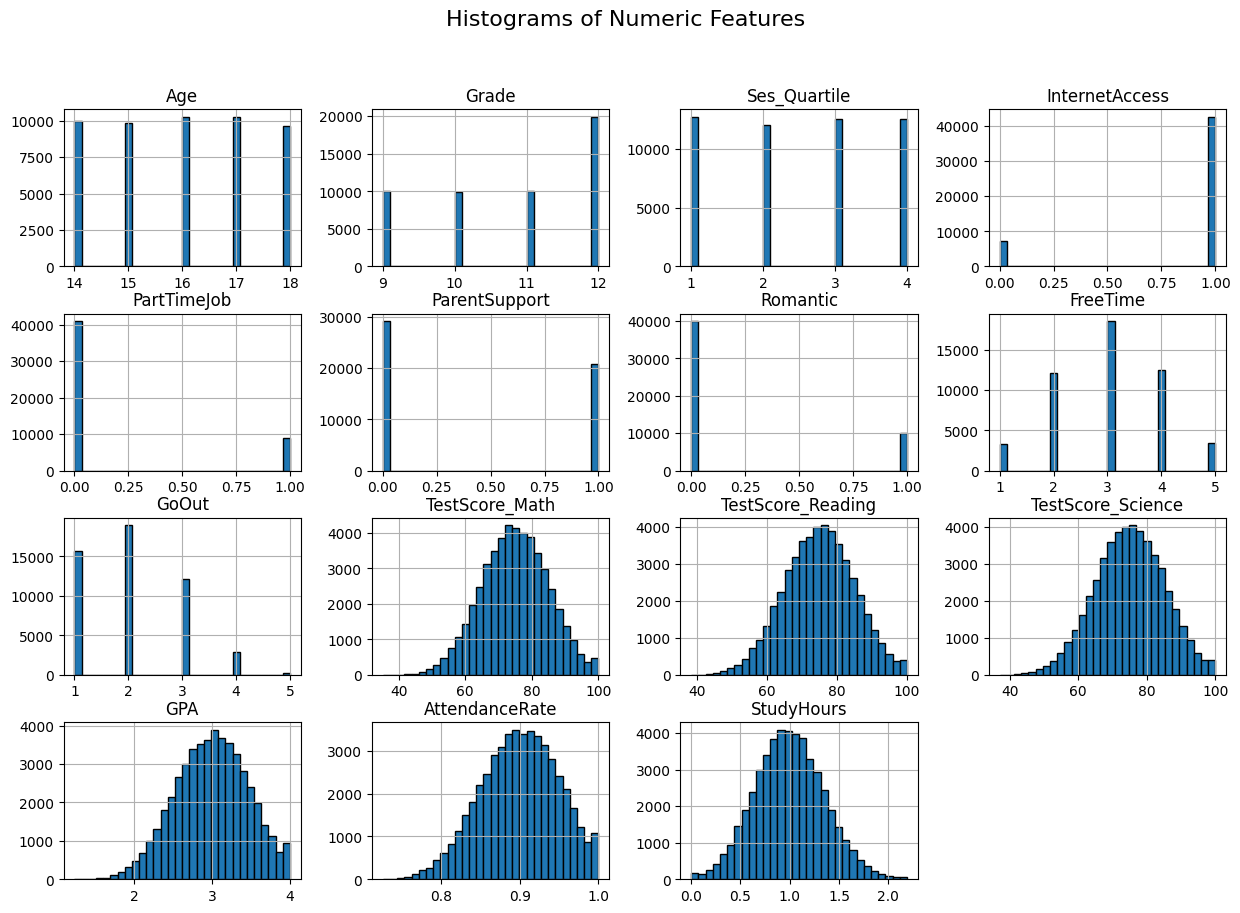

In [ ]:
# Histograms of numeric features
df.select_dtypes(include=[np.number]).hist(
    bins=30, figsize=(15, 10), edgecolor="black"
)
plt.suptitle("Histograms of Numeric Features", fontsize=16)
plt.show()



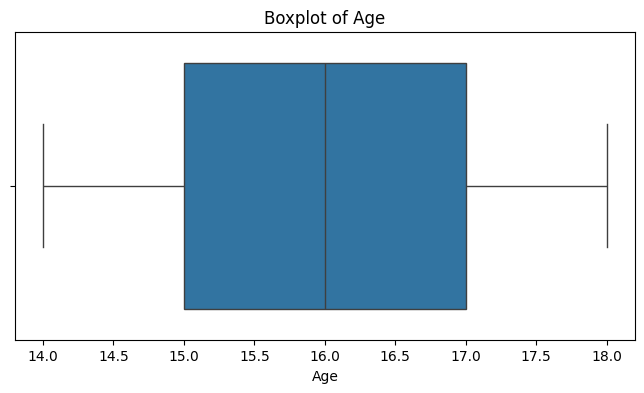

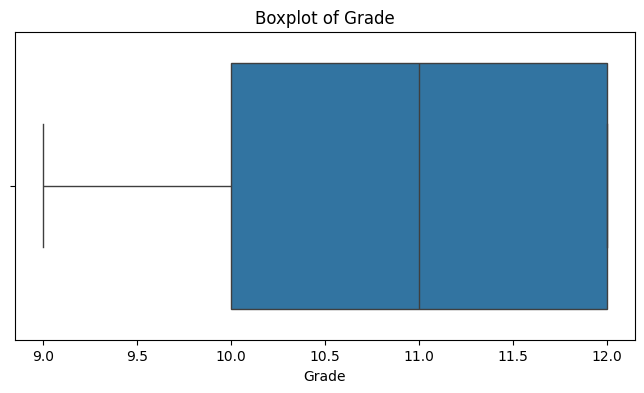

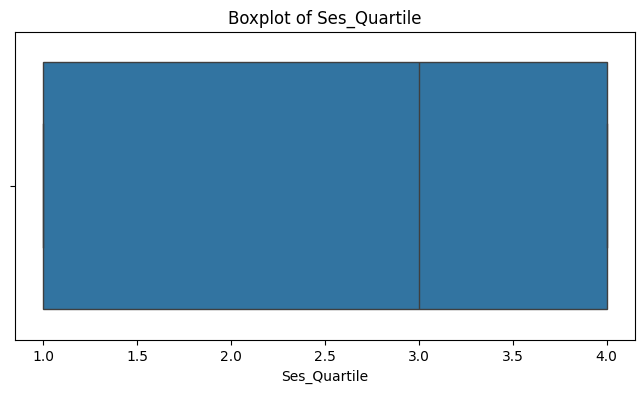

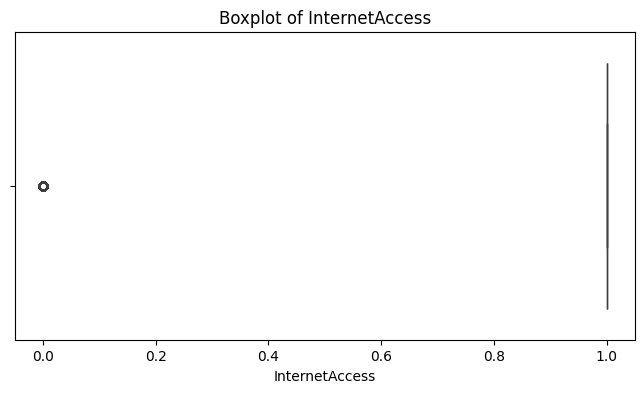

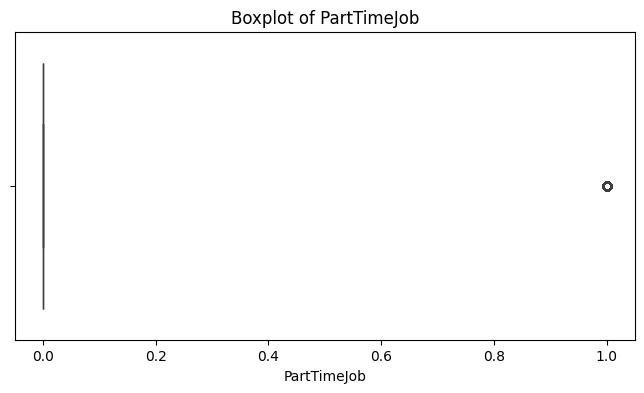

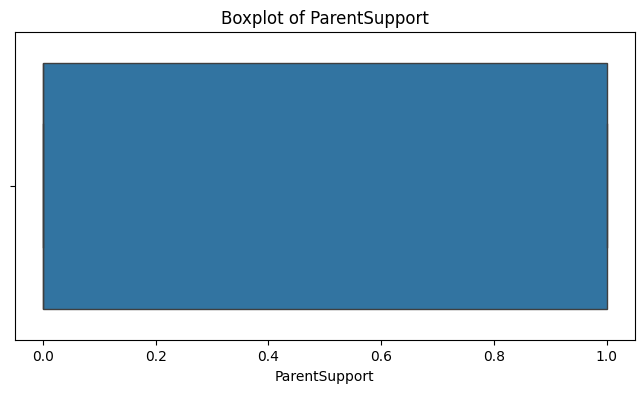

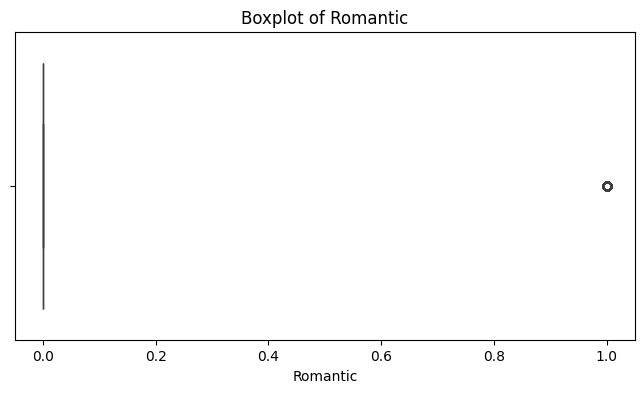

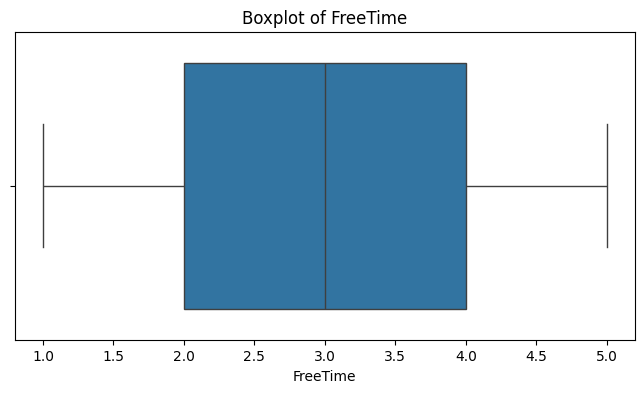

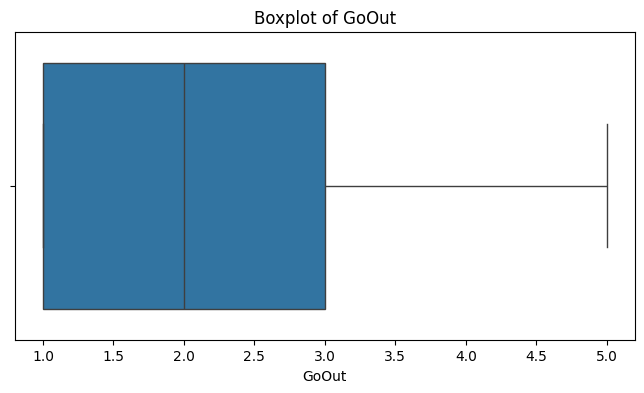

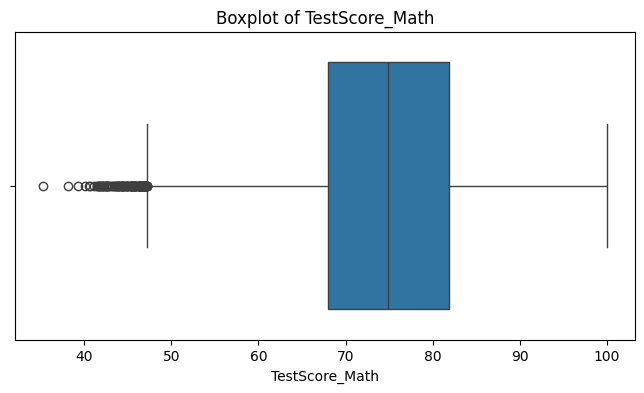

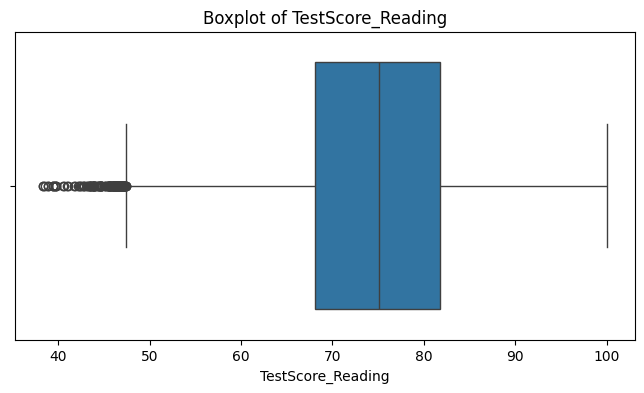

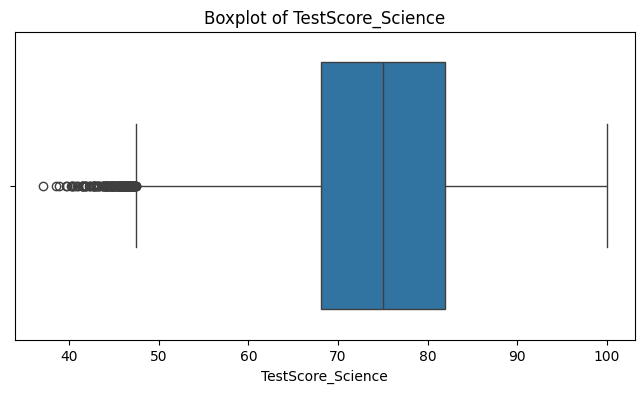

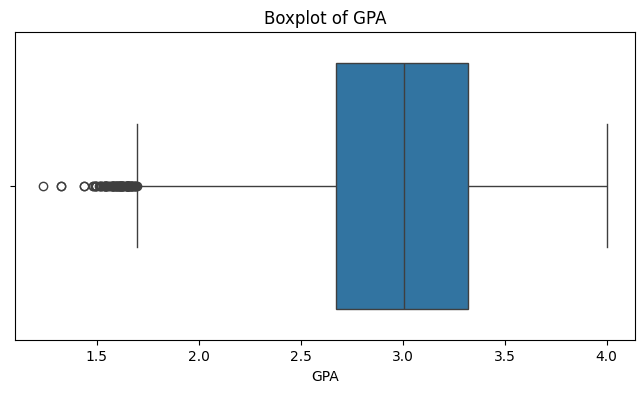

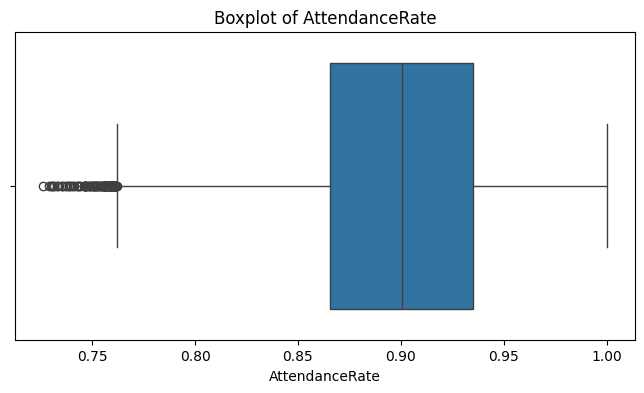

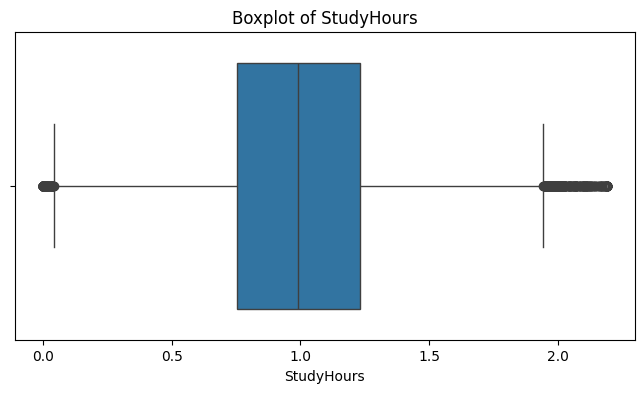

In [ ]:
# Boxplots of numerical features
for col in df.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()


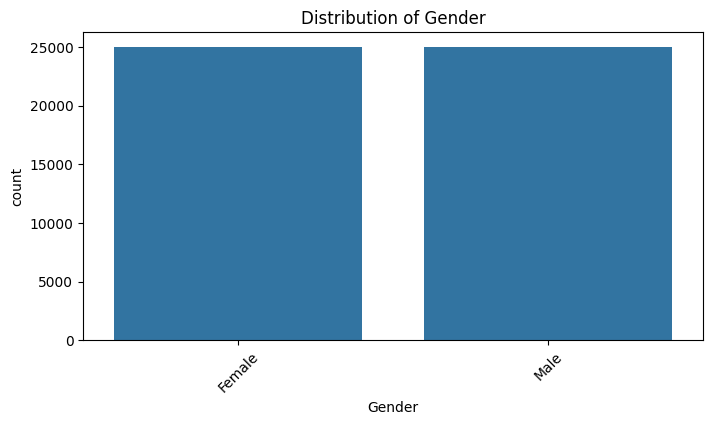

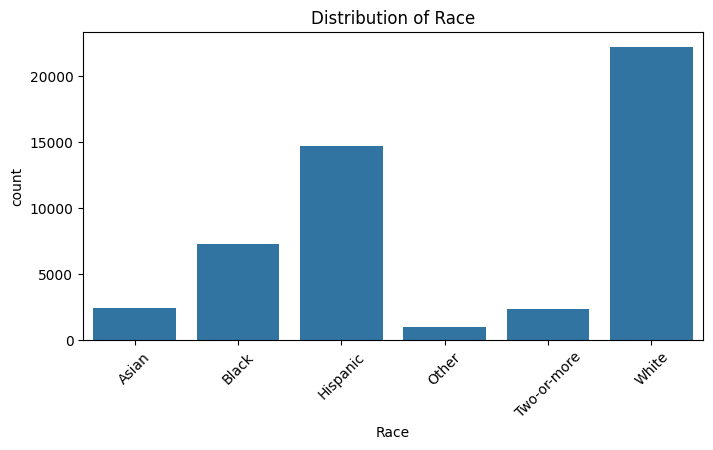

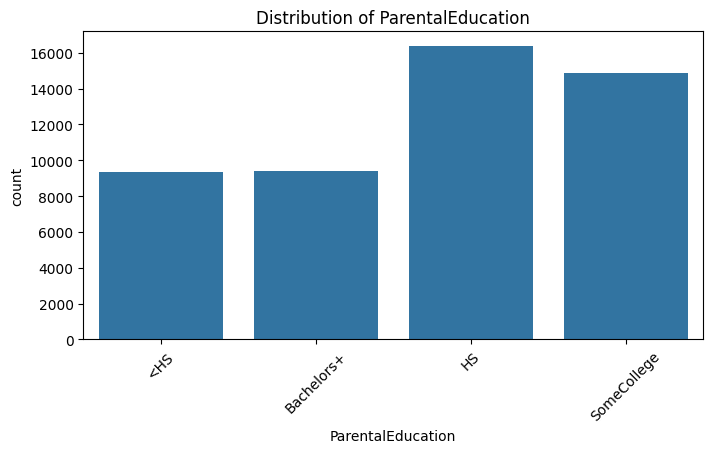

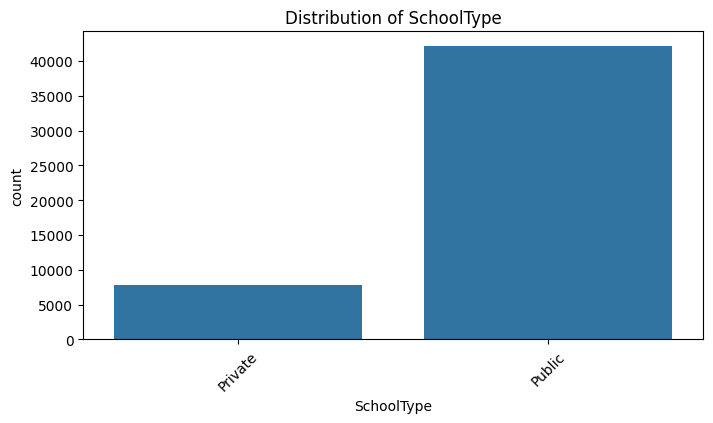

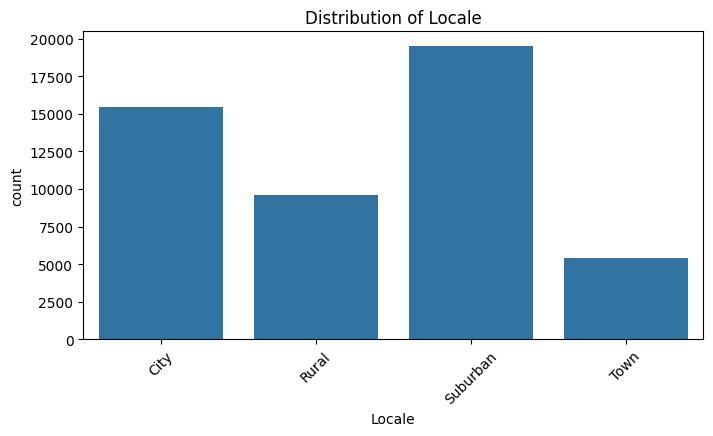

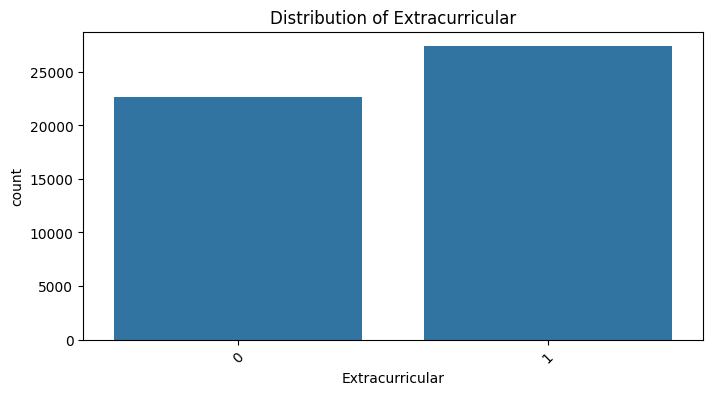

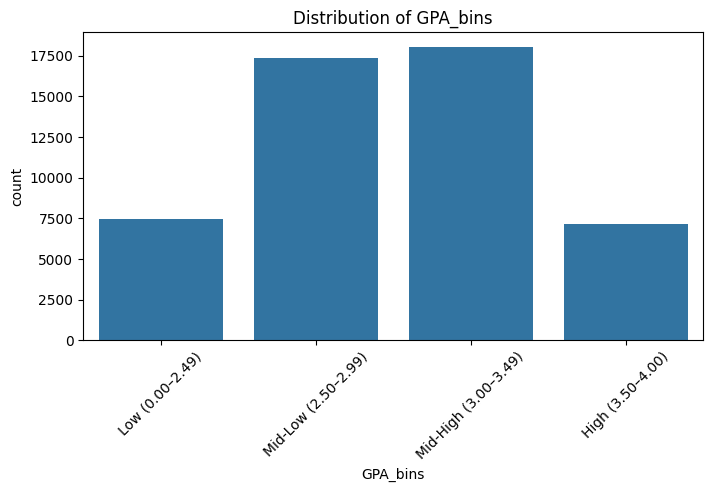

In [ ]:
# Countplot of categorical feature(target variable)
for col in df.select_dtypes(include="category").columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=df)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()


# Feature Selection

In [ ]:
print(df.columns)

Index(['Age', 'Grade', 'Ses_Quartile', 'InternetAccess', 'PartTimeJob',
       'ParentSupport', 'Romantic', 'FreeTime', 'GoOut', 'Gender', 'Race',
       'ParentalEducation', 'SchoolType', 'Locale', 'TestScore_Math',
       'TestScore_Reading', 'TestScore_Science', 'GPA', 'AttendanceRate',
       'StudyHours', 'Extracurricular', 'GPA_bins'],
      dtype='object')


In [ ]:
# Select numeric features
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric Features:")
for col in numeric_features:
    print(f"  - {col}")


Numeric Features:
  - Age
  - Grade
  - Ses_Quartile
  - InternetAccess
  - PartTimeJob
  - ParentSupport
  - Romantic
  - FreeTime
  - GoOut
  - TestScore_Math
  - TestScore_Reading
  - TestScore_Science
  - GPA
  - AttendanceRate
  - StudyHours


In [ ]:
# Categorical features
categorical_features = df.select_dtypes(include=["object", "category"]).columns.tolist()
print("\nCategorical Features:")
for col in categorical_features:
    print(f"  - {col}")



Categorical Features:
  - Gender
  - Race
  - ParentalEducation
  - SchoolType
  - Locale
  - Extracurricular
  - GPA_bins


In [ ]:
df.GPA_bins

,GPA_bins
0,Mid-Low (2.50–2.99)
1,Mid-High (3.00–3.49)
2,Mid-Low (2.50–2.99)
3,Low (0.00–2.49)
4,Mid-High (3.00–3.49)
...,...
49995,Mid-High (3.00–3.49)
49996,Mid-Low (2.50–2.99)
49997,Mid-Low (2.50–2.99)
49998,Mid-High (3.00–3.49)


PCA reduced 15 features → 12 components


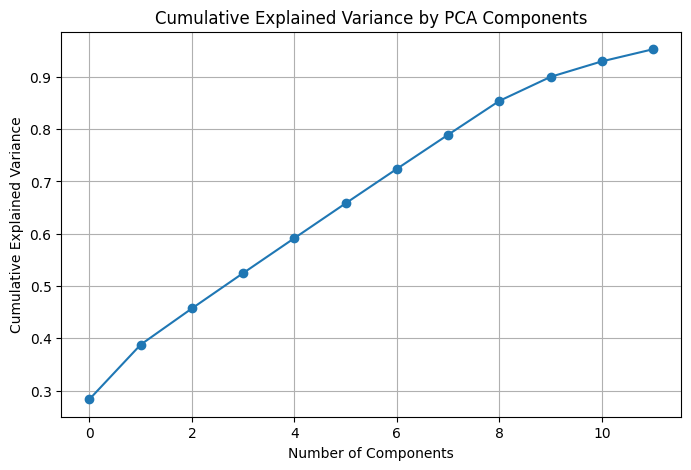

In [ ]:
scaler = StandardScaler()
scaled_numeric = scaler.fit_transform(df[numeric_features])

# Apply PCA (retain 95% variance)
pca = PCA(n_components=0.95)
pca_numeric = pca.fit_transform(scaled_numeric)

# PCA Summary
print(f"PCA reduced {len(numeric_features)} features → {pca.n_components_} components")

# Create PCA DataFrame
pca_columns = [f"PCA_{i+1}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_numeric, columns=pca_columns)

# Replace numeric features in original df
df_pca = pd.concat([df.drop(columns=numeric_features).reset_index(drop=True), pca_df], axis=1)

# Scree Plot (Variance Explained)
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

Numeric features: ['Age', 'Grade', 'Ses_Quartile', 'InternetAccess', 'PartTimeJob', 'ParentSupport', 'Romantic', 'FreeTime', 'GoOut', 'TestScore_Math', 'TestScore_Reading', 'TestScore_Science', 'GPA', 'AttendanceRate', 'StudyHours']
Categorical features: ['Gender', 'Race', 'ParentalEducation', 'SchoolType', 'Locale', 'Extracurricular', 'GPA_bins']
PCA reduced 15 features → 12 components


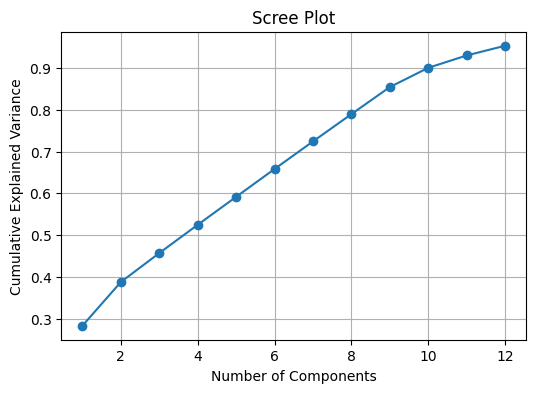

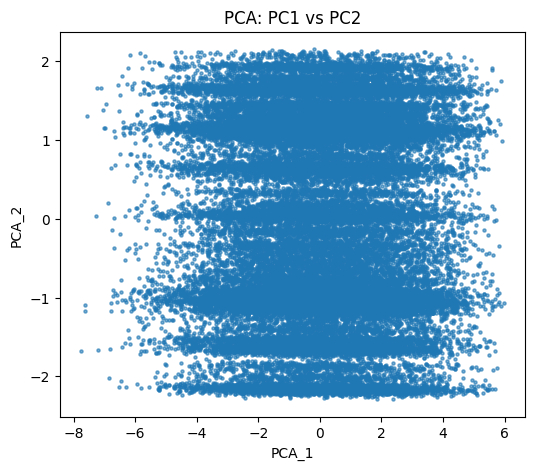

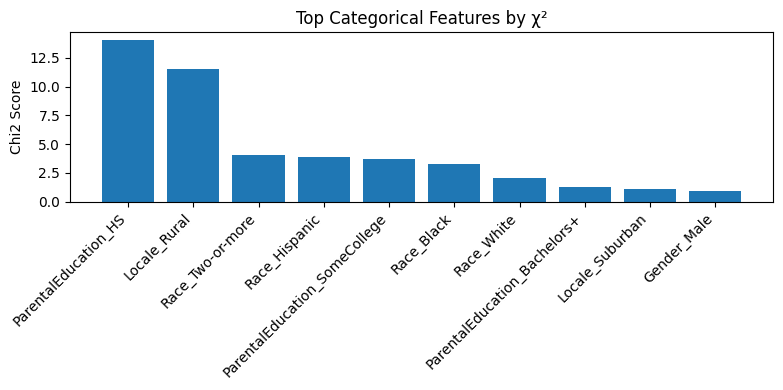

Transformed df_selected shape: (50000, 15)


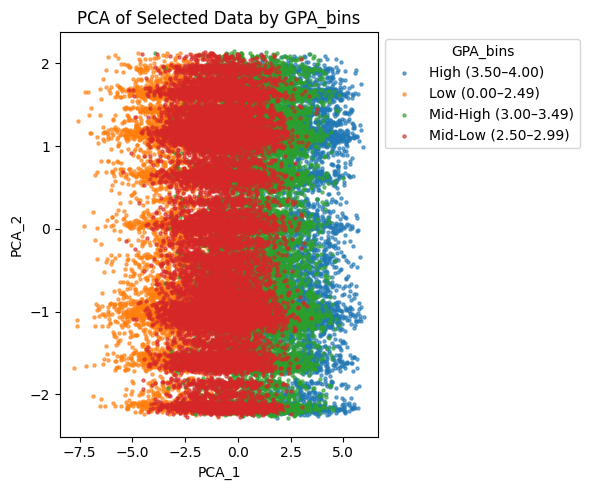

In [ ]:
# -------------------------------------
# Part 0: Inspect & auto-detect features
# -------------------------------------
target = "GPA_bins"
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# -------------------------------------
# Part 1: PCA on Numeric Features
# -------------------------------------
scaler      = StandardScaler()
X_num_scaled= scaler.fit_transform(df[numeric_features])
pca         = PCA(n_components=0.95, random_state=42)
X_pca       = pca.fit_transform(X_num_scaled)
pca_cols    = [f"PCA_{i+1}" for i in range(pca.n_components_)]
pca_df      = pd.DataFrame(X_pca, columns=pca_cols, index=df.index)
print(f"PCA reduced {len(numeric_features)} features → {pca.n_components_} components")

# -------------------------------------
# Part 2: Visualize PCA Results
# -------------------------------------
plt.figure(figsize=(6,4))
plt.plot(
    np.arange(1, len(pca.explained_variance_ratio_)+1),
    np.cumsum(pca.explained_variance_ratio_), marker='o'
)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Scree Plot")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(pca_df["PCA_1"], pca_df["PCA_2"], s=5, alpha=0.6)
plt.xlabel("PCA_1")
plt.ylabel("PCA_2")
plt.title("PCA: PC1 vs PC2")
plt.show()

# -------------------------------------
# Part 3: χ² Feature Selection on Categorical
# -------------------------------------
cat_feats   = [c for c in categorical_features if c != target]
le           = LabelEncoder()
y            = le.fit_transform(df[target])
ohe          = OneHotEncoder(drop="first", sparse_output=False)
X_cat        = ohe.fit_transform(df[cat_feats])
cat_feat_names = ohe.get_feature_names_out(cat_feats)
chi_scores, p_values = chi2(X_cat, y)
chi2_df      = pd.DataFrame({
    "Feature": cat_feat_names,
    "Chi2 Score": chi_scores,
    "p-value": p_values
}).sort_values("Chi2 Score", ascending=False).reset_index(drop=True)

# -------------------------------------
# Part 4: Visualize χ² Results
# -------------------------------------
top_k = min(10, len(chi2_df))
plt.figure(figsize=(8,4))
plt.bar(range(top_k), chi2_df["Chi2 Score"].iloc[:top_k])
plt.xticks(range(top_k), chi2_df["Feature"].iloc[:top_k], rotation=45, ha='right')
plt.ylabel("Chi2 Score")
plt.title("Top Categorical Features by χ²")
plt.tight_layout()
plt.show()

# -------------------------------------
# Part 5: Transform Dataset Based on Selected Features
# -------------------------------------
significant_features   = chi2_df.loc[chi2_df["p-value"] < 0.1, "Feature"].tolist()
significant_features = significant_features
X_cat_df    = pd.DataFrame(X_cat, columns=cat_feat_names, index=df.index)
X_sig_df    = X_cat_df[significant_features].astype("uint8")
df_selected = pd.concat([pca_df, X_sig_df, df[[target]]], axis=1)
print("Transformed df_selected shape:", df_selected.shape)

# -------------------------------------
# Part 6: Visualize Transformed Dataset
# -------------------------------------
plt.figure(figsize=(6,5))
for lbl in sorted(df_selected[target].unique()):
    mask = df_selected[target] == lbl
    plt.scatter(
        df_selected.loc[mask, "PCA_1"],
        df_selected.loc[mask, "PCA_2"], s=5, alpha=0.6, label=str(lbl)
    )
plt.xlabel("PCA_1")
plt.ylabel("PCA_2")
plt.title("PCA of Selected Data by GPA_bins")
plt.legend(title="GPA_bins", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

In [ ]:
# # Take a manageable random sample
# SAMPLE_SIZE = 200_000
# df_sample = df.sample(n=min(SAMPLE_SIZE, len(df)), random_state=42)

# # Encode the target
# le       = LabelEncoder()
# y_sample = le.fit_transform(df_sample["GPA_bins"])

# # Prepare categorical feature list (exclude the target column itself)
# cats = [c for c in categorical_features if c != "GPA_bins"]
# print("Using categorical features:", cats)

# # One-hot encode into a sparse matrix
# ohe      = OneHotEncoder(drop='first')
# X_cat = ohe.fit_transform(df_sample[cats])

# # Compute χ² on the sparse matrix
# chi_scores, p_values = chi2(X_sparse, y_sample)

# # Collect results
# feat_names = ohe.get_feature_names_out(cats)
# chi2_df = (
#     pd.DataFrame({
#         "Feature":    feat_names,
#         "Chi2 Score": chi_scores,
#         "p-value":    p_values
#     })
#     .sort_values("Chi2 Score", ascending=False)
#     .reset_index(drop=True)
# )

# print("Top χ² features (sampled):")
# print(chi2_df.head(20))

In [ ]:
# # Encode target variable
# target = "GPA_bins"
# y_encoded = LabelEncoder().fit_transform(df[target])

# # Select categorical features
# categorical_features = [
#     col for col in categorical_features if col != target
# ]
# print("Categorical Features:", categorical_features)

# # One-hot encode categorical features
# X_cat = pd.get_dummies(df[categorical_features], drop_first=True)

# # Apply Chi-square test
# chi_scores, p_values = chi2(X_cat, y_encoded)

# # Chi squared Results DataFrame
# chi2_df = pd.DataFrame({
#     "Feature": X_cat.columns,
#     "Chi2 Score": chi_scores,
#     "p-value": p_values
# }).sort_values("Chi2 Score", ascending=False)

# print("Chi squared Feature Ranking:")
# print(chi2_df)



In [ ]:
# # Keep features with p-value < 0.1
# significant_features = chi2_df[chi2_df["p-value"] < 0.1]["Feature"].tolist()

# print(f"Statistically Significant Features (p < 0.1): {len(significant_features)}")
# print(significant_features)


In [ ]:
# # Keep only significant dummy features from X_cat
# X_cat_significant = X_cat[significant_features]

# # Combine PCA components + significant categorical features + target
# df_selected = pd.concat([
#     pca_df.reset_index(drop=True),
#     X_cat_significant.reset_index(drop=True),
#     df[target].reset_index(drop=True)
# ], axis=1)

# print(f"\Final df_selected Shape: {df_selected.shape}")
# print(df_selected.head())

In [ ]:
df_target = df["GPA_bins"]
df = df_selected

In [ ]:
# Save important transformers and feature lists
saved_scaler = scaler
saved_pca = pca
saved_features = significant_features
original_numeric_features = numeric_features
original_categorical_features = categorical_features


In [ ]:
print(saved_features)
print(original_numeric_features)
print(original_categorical_features)

['ParentalEducation_HS', 'Locale_Rural']
['Age', 'Grade', 'Ses_Quartile', 'InternetAccess', 'PartTimeJob', 'ParentSupport', 'Romantic', 'FreeTime', 'GoOut', 'TestScore_Math', 'TestScore_Reading', 'TestScore_Science', 'GPA', 'AttendanceRate', 'StudyHours']
['Gender', 'Race', 'ParentalEducation', 'SchoolType', 'Locale', 'Extracurricular', 'GPA_bins']


# Training and Hyperparameter Tuning

In [ ]:
X = df
y = df_target

# Prepare target variable for training
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Use class weights to address imbalance of target categories
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_encoded),
    y=y_encoded
)
weight_dict = {i: w for i, w in enumerate(class_weights)}

# Make sure correct datatype is used
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype("category")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

sample_weights = np.array([weight_dict[label] for label in y_train])

In [ ]:
# Get subest
max_rows = 100_000

if len(df_selected) > max_rows:
    df_subset = df_selected.sample(n=max_rows, random_state=42)
    print(f"Subset limited to {max_rows} rows for Optuna.")
else:
    df_subset = df_selected.copy()
    print(f"Using all {len(df_subset)} rows (data <= {max_rows}).")

X = df_subset.drop(columns=[target])
y = LabelEncoder().fit_transform(df_subset[target])

# Split subset into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# Set range of parameters
def objective(trial):
    params = {
        "objective": "multi:softprob",
        "num_class": 4,
        "eval_metric": "mlogloss",
        "enable_categorical": True,
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1.0),
        "random_state": 42,
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)

# Start Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

Using all 50000 rows (data <= 100000).


[I 2025-07-31 04:55:22,237] A new study created in memory with name: no-name-dff8d1d4-c82d-4aa9-874d-bb1f76345a0e
[I 2025-07-31 04:55:33,886] Trial 0 finished with value: 0.9321 and parameters: {'max_depth': 9, 'learning_rate': 0.04796072239482339, 'n_estimators': 282, 'subsample': 0.701672316326218, 'colsample_bytree': 0.5262244467835316, 'gamma': 0.9818392033320881, 'reg_alpha': 0.44613134362699913, 'reg_lambda': 0.7512725270612756}. Best is trial 0 with value: 0.9321.
[I 2025-07-31 04:55:50,020] Trial 1 finished with value: 0.934 and parameters: {'max_depth': 10, 'learning_rate': 0.025837359602501043, 'n_estimators': 182, 'subsample': 0.8844101512883655, 'colsample_bytree': 0.8306302429510024, 'gamma': 0.634491177928228, 'reg_alpha': 0.8217483288577847, 'reg_lambda': 0.4773604182746246}. Best is trial 1 with value: 0.934.
[I 2025-07-31 04:55:59,821] Trial 2 finished with value: 0.9379 and parameters: {'max_depth': 6, 'learning_rate': 0.09055943870682005, 'n_estimators': 238, 'subsam

In [ ]:
print("Best trial:")
print("Accuracy:", study.best_value)
print("Params:", study.best_params)

Best trial:
Accuracy: 0.94
Params: {'max_depth': 3, 'learning_rate': 0.17566789747941478, 'n_estimators': 298, 'subsample': 0.8168528638328687, 'colsample_bytree': 0.5973496793305704, 'gamma': 0.9090974201683353, 'reg_alpha': 0.34541290999292384, 'reg_lambda': 0.2826242335276166}


In [ ]:
# Prepare and Train Best model
best_model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=4,
    eval_metric="mlogloss",
    enable_categorical=True,
    **study.best_params
)
best_model.fit(X_train, y_train, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5973496793305704, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=0.9090974201683353, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.17566789747941478,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=298, n_jobs=None, num_class=4, ...)

# Visualize Results

TEST ACCURACY: 0.935,  MCC: 0.908

Classification Report:
                      precision    recall  f1-score   support

    High (3.50–4.00)       0.96      0.93      0.94      1425
     Low (0.00–2.49)       0.94      0.92      0.93      1493
Mid-High (3.00–3.49)       0.93      0.94      0.94      3609
 Mid-Low (2.50–2.99)       0.92      0.94      0.93      3473

            accuracy                           0.94     10000
           macro avg       0.94      0.93      0.94     10000
        weighted avg       0.94      0.94      0.94     10000



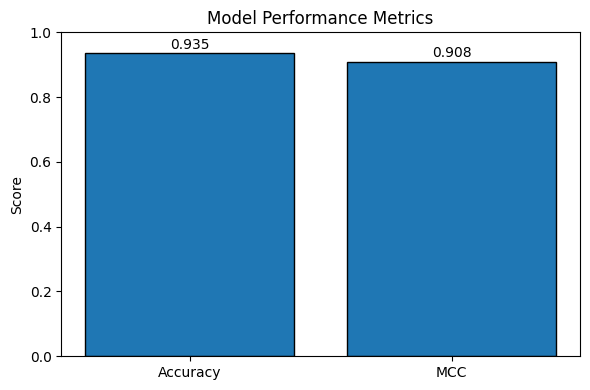

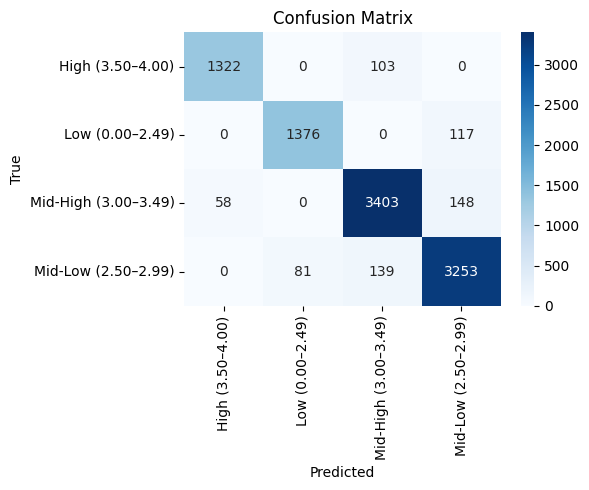

<Figure size 600x500 with 0 Axes>

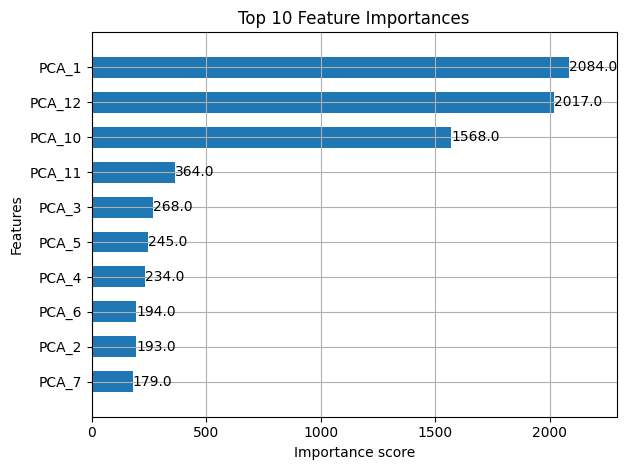

In [ ]:
y_pred = best_model.predict(X_test)
# Compute & Print Metrics ---
acc = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

print(f"TEST ACCURACY: {acc:.3f},  MCC: {mcc:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Bar Chart: Accuracy & MCC ---
metrics = ["Accuracy", "MCC"]
values  = [acc, mcc]

plt.figure(figsize=(6, 4))
bars = plt.bar(metrics, values, edgecolor="k")
for bar, val in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        val + 0.005,
        f"{val:.3f}",
        ha="center", va="bottom"
    )

# start y-axis at zero so heights are proportional
plt.ylim(0, 1.0)

plt.ylabel("Score")
plt.title("Model Performance Metrics")
plt.tight_layout()
plt.show()

# Confusion Matrix ---
plt.figure(figsize=(6, 5))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True, fmt="d",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cmap="Blues"
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Feature Importances ---
plt.figure(figsize=(6, 5))
xgb.plot_importance(best_model, max_num_features=10, height=0.6)
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()


In [ ]:
# # Combine df_selected with original target column
# df_combined = pd.concat([df_selected.reset_index(drop=True), df_target.reset_index(drop=True)], axis=1)

# # Save to CSV
# output_path = "student_performance_selected.csv"
# df_combined.to_csv(output_path, index=False)

# print(f"Combined DataFrame saved to: {output_path}")
# print(f"Shape of saved DataFrame: {df_combined.shape}")


# Compare performance against original data

In [ ]:
def preprocess_new_data(
    df_raw,
    scaler,
    pca,
    original_numeric_features,
    original_categorical_features,
    selected_cat_features
):

    # Build a case-insensitive mapping from lower->original for all features
    all_feats = list(original_numeric_features) + list(original_categorical_features)
    rename_map = {feat.lower(): feat for feat in all_feats}

    # Rename df_raw cols so they exactly match the training names
    df = df_raw.rename(columns=lambda c: rename_map.get(c.lower(), c)).copy()

    # Scale & PCA on numeric
    X_num = scaler.transform(df[original_numeric_features])
    X_pca = pca.transform(X_num)
    pca_cols = [f"PCA_{i+1}" for i in range(pca.n_components_)]
    df_pca = pd.DataFrame(X_pca, columns=pca_cols, index=df.index)

    # One‐hot the categorical (using the original feature names)
    df_dummies = pd.get_dummies(df[original_categorical_features], drop_first=True)

    # 5Ensure all your selected dummy columns exist
    for col in selected_cat_features:
        if col not in df_dummies.columns:
            df_dummies[col] = 0

    # Keep only those selected
    df_dummies = df_dummies[selected_cat_features]

    # Combine PCA + dummies
    df_final = pd.concat([df_pca, df_dummies], axis=1)

    return df_final


In [ ]:
# Load original data
train_df = pd.read_csv("student-performance/train.csv")
test_df  = pd.read_csv("student-performance/test.csv")
val_df   = pd.read_csv("student-performance/validation.csv")

# Concatenate all splits
raw = pd.concat([train_df, test_df, val_df], ignore_index=True)

# Define GPA category binning function
def add_gpa_category(df):
    bins = [0, 2.5, 3.0, 3.5, 4.1]
    labels = ["Low (0.00–2.49)", "Mid-Low (2.50–2.99)",
              "Mid-High (3.00–3.49)", "High (3.50–4.00)"]
    df["Gpa_Category"] = pd.cut(df["GPA"], bins=bins, labels=labels, include_lowest=True)
    return df

# Define your full feature cleanup function
def build_full_df(df):
    # You would put your join/lookup merge logic here, e.g.:
    # df = df.merge(school_dim, on="SchoolID").drop("SchoolID", axis=1)
    # df = df.rename(columns={"Gender": "GenderLabel", ...})
    # For now, we assume this is a pass-through
    return df

# Apply transformation pipeline
df_full = build_full_df(raw)
df_clean = df_full.loc[:, ~df_full.columns.str.lower().str.contains("id")]
df_clean = add_gpa_category(df_clean)
df_new = df_clean.dropna().drop_duplicates()
label_encoder = LabelEncoder()
y_true = df_new["Gpa_Category"].astype(str)
y_true_enc = label_encoder.fit_transform(y_true)

# Transform features with saved preprocessing pipeline ===
X_new = preprocess_new_data(
    df_raw=df_new,
    scaler=saved_scaler,
    pca=saved_pca,
    original_numeric_features=original_numeric_features,
    original_categorical_features=original_categorical_features,
    selected_cat_features=saved_features
)

if X_new.columns.to_list() == X.columns.to_list():
    print("PCA is correctly applied.")
else:
    print("PCA is not correctly applied.")

# Train new model with best Optuna parameters
best_params = study.best_params  # or hard-code your best param dict
model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=4,
    eval_metric="mlogloss",
    enable_categorical=True,
    random_state=42,
    **best_params
)

model.fit(X_new, y_true_enc)

# Evaluate
y_pred = model.predict(X_new)
print("✅ Accuracy of the model trained on original data:", accuracy_score(y_true_enc, y_pred))
print(classification_report(y_true_enc, y_pred, target_names=label_encoder.classes_))


KeyError: "['GPA_bins'] not in index"

In [ ]:
# features+labels
y_all = label_encoder.transform(df_new["Gpa_Category"].astype(str))
X_all = preprocess_new_data(
    df_raw=df_new,
    scaler=saved_scaler,
    pca=saved_pca,
    original_numeric_features=original_numeric_features,
    original_categorical_features=original_categorical_features,
    selected_cat_features=saved_features
)

# 80/20 split
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_all,
    y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)

# Train
model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=4,
    eval_metric="mlogloss",
    enable_categorical=True,
    random_state=42,
    **study.best_params
)
model.fit(X_train_orig, y_train_orig)

# Evaluate
y_pred_orig = model.predict(X_test_orig)
print("Original‑test Accuracy:", accuracy_score(y_test_orig, y_pred_orig))
print(classification_report(y_test_orig, y_pred_orig, target_names=label_encoder.classes_))


In [ ]:
# Predict
y_pred_synth_on_orig = best_model.predict(X_test_orig)

# Evaluate
print("Accuracy of synthetic‑trained model on original test:",
      accuracy_score(y_test_orig, y_pred_synth_on_orig))
print(classification_report(
    y_test_orig,
    y_pred_synth_on_orig,
    target_names=label_encoder.classes_
))


In [ ]:
# Compute Metrics
acc_orig = accuracy_score(y_test_orig, y_pred_orig)
mcc_orig = matthews_corrcoef(y_test_orig, y_pred_orig)

acc_synth = accuracy_score(y_test_orig, y_pred_synth_on_orig)
mcc_synth = matthews_corrcoef(y_test_orig, y_pred_synth_on_orig)

print(f"ORIG‑TRAIN → TEST ACC: {acc_orig:.3f},  MCC: {mcc_orig:.3f}")
print(classification_report(y_test_orig, y_pred_orig, target_names=label_encoder.classes_))
print("-" * 60)
print(f"SYNTH‑TRAIN → TEST ACC: {acc_synth:.3f},  MCC: {mcc_synth:.3f}")
print(classification_report(y_test_orig, y_pred_synth_on_orig, target_names=label_encoder.classes_))

# Accuracy Bar Chart
labels = ["Orig-Train", "Synth-Train"]
acc_values = [acc_orig, acc_synth]

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(labels, acc_values, edgecolor="k")
for i, v in enumerate(acc_values):
    ax.text(i, v + 0.005, f"{v:.3f}", ha="center")

# Force y-axis from 0 to 1
ax.set_ylim(0, 1.0)
ax.set_ylabel("Accuracy")
ax.set_title("Detailed Test Accuracy Comparison")
ax.set_yticks(np.linspace(0, 1.0, 5))

plt.tight_layout()
plt.show()

# MCC Bar Chart
labels = ["Orig-Train", "Synth-Train"]
mcc_values = [mcc_orig, mcc_synth]

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(labels, mcc_values, color="tab:red", edgecolor="k")
for i, v in enumerate(mcc_values):
    ax.text(i, v + 0.005, f"{v:.3f}", ha="center")

# Force y-axis from 0 to 1
ax.set_ylim(0, 1.0)
ax.set_ylabel("MCC")
ax.set_title("Detailed Matthews Correlation Coefficient Comparison")
ax.set_yticks(np.linspace(0, 1.0, 5))

plt.tight_layout()
plt.show()

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.heatmap(confusion_matrix(y_test_orig, y_pred_orig), annot=True, fmt="d",
            ax=axes[0], xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
axes[0].set(title="CM: Orig‑Train Model", xlabel="Predicted", ylabel="True")

sns.heatmap(confusion_matrix(y_test_orig, y_pred_synth_on_orig), annot=True, fmt="d",
            ax=axes[1], xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
axes[1].set(title="CM: Synth‑Train Model", xlabel="Predicted")

plt.tight_layout()
plt.show()

# Feature Importances
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
xgb.plot_importance(model, max_num_features=10, ax=axes[0])
axes[0].set_title("Importances (Trained on Original)")

xgb.plot_importance(best_model, max_num_features=10, ax=axes[1])
axes[1].set_title("Importances (Trained on Synthetic)")

plt.tight_layout()
plt.show()


# Test on human created data

In [ ]:
# GPA bin mapping
gpa_bin_dict = {
    "High": "High (3.50–4.00)",
    "Mid-High": "Mid-High (3.00–3.49)",
    "Mid-Low": "Mid-Low (2.50–2.99)",
    "Low": "Low (0.00–2.49)"
}

# Manual datapoints with keys matching the database schema exactly
student_data = [
    # 1. Typical Mid‑Low suburban student
    {"Age":17,"Grade":12,"Gender":"Female","Race":"White","SES_Quartile":3,
     "ParentalEducation":"HS","SchoolType":"Public","Locale":"Suburban",
     "TestScore_Math":70.3,"TestScore_Reading":79.7,"TestScore_Science":80.8,
     "GPA":2.74,"AttendanceRate":0.91,"StudyHours":1.09,"InternetAccess":1,
     "Extracurricular":1,"PartTimeJob":0,"ParentSupport":0,"Romantic":0,
     "FreeTime":2,"GoOut":2,"Gpa_Category":"Mid-Low (2.50–2.99)"},

    # 2. Borderline Mid‑Low with low reading
    {"Age":18,"Grade":12,"Gender":"Female","Race":"White","SES_Quartile":2,
     "ParentalEducation":"HS","SchoolType":"Public","Locale":"Suburban",
     "TestScore_Math":67.9,"TestScore_Reading":59.6,"TestScore_Science":70.9,
     "GPA":2.59,"AttendanceRate":0.84,"StudyHours":0.88,"InternetAccess":1,
     "Extracurricular":1,"PartTimeJob":0,"ParentSupport":1,"Romantic":0,
     "FreeTime":5,"GoOut":2,"Gpa_Category":"Mid-Low (2.50–2.99)"},

    # 3. Low‑achiever struggling academically
    {"Age":16,"Grade":11,"Gender":"Female","Race":"White","SES_Quartile":2,
     "ParentalEducation":"HS","SchoolType":"Public","Locale":"City",
     "TestScore_Math":62.1,"TestScore_Reading":70.6,"TestScore_Science":60.6,
     "GPA":2.43,"AttendanceRate":0.85,"StudyHours":1.00,"InternetAccess":1,
     "Extracurricular":1,"PartTimeJob":0,"ParentSupport":1,"Romantic":1,
     "FreeTime":5,"GoOut":1,"Gpa_Category":"Low (0.00–2.49)"},

    # 4. High‑achiever with supportive parents
    {"Age":14,"Grade":9,"Gender":"Female","Race":"White","SES_Quartile":4,
     "ParentalEducation":"Bachelors+","SchoolType":"Public","Locale":"Town",
     "TestScore_Math":79.9,"TestScore_Reading":82.9,"TestScore_Science":85.6,
     "GPA":3.56,"AttendanceRate":0.95,"StudyHours":1.81,"InternetAccess":1,
     "Extracurricular":1,"PartTimeJob":0,"ParentSupport":1,"Romantic":0,
     "FreeTime":4,"GoOut":2,"Gpa_Category":"High (3.50–4.00)"},

    # 5. Extreme low achiever, low support & attendance
    {"Age":15,"Grade":10,"Gender":"Male","Race":"Black","SES_Quartile":1,
     "ParentalEducation":"<HS","SchoolType":"Public","Locale":"Urban",
     "TestScore_Math":30.0,"TestScore_Reading":35.0,"TestScore_Science":40.0,
     "GPA":1.20,"AttendanceRate":0.60,"StudyHours":0.50,"InternetAccess":0,
     "Extracurricular":0,"PartTimeJob":1,"ParentSupport":0,"Romantic":1,
     "FreeTime":5,"GoOut":5,"Gpa_Category":"Low (0.00–2.49)"},

    # 6. Extreme high achiever, graduate‑educated parents
    {"Age":17,"Grade":12,"Gender":"Female","Race":"Asian","SES_Quartile":4,
     "ParentalEducation":"Graduate","SchoolType":"Private","Locale":"Suburban",
     "TestScore_Math":99.0,"TestScore_Reading":98.0,"TestScore_Science":97.0,
     "GPA":4.00,"AttendanceRate":1.00,"StudyHours":3.00,"InternetAccess":1,
     "Extracurricular":1,"PartTimeJob":0,"ParentSupport":1,"Romantic":0,
     "FreeTime":1,"GoOut":1,"Gpa_Category":"High (3.50–4.00)"},

    # 7. Strong academics but no parent support (<HS vs Graduate)
    {"Age":16,"Grade":11,"Gender":"Female","Race":"Hispanic","SES_Quartile":3,
     "ParentalEducation":"<HS","SchoolType":"Public","Locale":"Town",
     "TestScore_Math":85.0,"TestScore_Reading":88.0,"TestScore_Science":90.0,
     "GPA":3.80,"AttendanceRate":0.95,"StudyHours":2.00,"InternetAccess":1,
     "Extracurricular":1,"PartTimeJob":0,"ParentSupport":0,"Romantic":0,
     "FreeTime":2,"GoOut":2,"Gpa_Category":"High (3.50–4.00)"},

    # 8. Same stats but graduate‑educated parents
    {"Age":16,"Grade":11,"Gender":"Female","Race":"Hispanic","SES_Quartile":3,
     "ParentalEducation":"Graduate","SchoolType":"Public","Locale":"Town",
     "TestScore_Math":85.0,"TestScore_Reading":88.0,"TestScore_Science":90.0,
     "GPA":3.80,"AttendanceRate":0.95,"StudyHours":2.00,"InternetAccess":1,
     "Extracurricular":1,"PartTimeJob":0,"ParentSupport":1,"Romantic":0,
     "FreeTime":2,"GoOut":2,"Gpa_Category":"High (3.50–4.00)"},

    # 9. Mid‑High achiever, private school, lots of extracurriculars
    {"Age":16,"Grade":10,"Gender":"Male","Race":"White","SES_Quartile":4,
     "ParentalEducation":"Bachelors+","SchoolType":"Private","Locale":"Suburban",
     "TestScore_Math":78.0,"TestScore_Reading":80.0,"TestScore_Science":75.0,
     "GPA":3.20,"AttendanceRate":0.93,"StudyHours":1.50,"InternetAccess":1,
     "Extracurricular":3,"PartTimeJob":0,"ParentSupport":1,"Romantic":0,
     "FreeTime":3,"GoOut":2,"Gpa_Category":"Mid-High (3.00–3.49)"},

    # 10. Mid‑Low achiever, high go‑out, low study hours
    {"Age":17,"Grade":11,"Gender":"Male","Race":"Two-or-more","SES_Quartile":2,
     "ParentalEducation":"SomeCollege","SchoolType":"Public","Locale":"Suburban",
     "TestScore_Math":65.0,"TestScore_Reading":60.0,"TestScore_Science":68.0,
     "GPA":2.75,"AttendanceRate":0.88,"StudyHours":0.70,"InternetAccess":1,
     "Extracurricular":0,"PartTimeJob":1,"ParentSupport":0,"Romantic":1,
     "FreeTime":4,"GoOut":5,"Gpa_Category":"Mid-Low (2.50–2.99)"}
]

# Create DataFrame
df_small = pd.DataFrame(student_data)

# Convert to DataFrame
df_small = pd.DataFrame(student_data)

# Display to confirm
print(df_small)

In [ ]:


# # 3. Lowercase all column names (important for consistent preprocessing)
# df_small.columns = [col.lower() for col in df_small.columns]

# # 4. Preprocessing function
# def preprocess_new_data(df_raw,
#                         scaler,
#                         pca,
#                         original_numeric_features,
#                         original_categorical_features,
#                         selected_cat_features):
#     """
#     Preprocess new raw data using saved transformers:
#     - Ensures lowercase column consistency
#     - Scales numeric features
#     - Applies PCA
#     - One-hot encodes categorical features
#     - Selects significant categorical features only
#     """

#     # Copy and normalize column names
#     df_raw = df_raw.copy()
#     df_raw.columns = [col.lower() for col in df_raw.columns]

#     # Normalize feature name lists
#     numeric_features = [col.lower() for col in original_numeric_features]
#     categorical_features = [col.lower() for col in original_categorical_features]
#     selected_cat_features = [col for col in selected_cat_features]  # these are one-hot column names

#     # Scale + PCA on numeric features
#     scaled_numeric = scaler.transform(df_raw[numeric_features])
#     pca_transformed = pca.transform(scaled_numeric)
#     pca_df = pd.DataFrame(pca_transformed, columns=[f"pca_{i+1}" for i in range(pca.n_components_)])

#     # One-hot encode categorical features
#     df_cat = pd.get_dummies(df_raw[categorical_features], drop_first=True)

#     # Ensure all expected columns are present
#     for col in selected_cat_features:
#         if col not in df_cat.columns:
#             df_cat[col] = 0
#     df_cat = df_cat[selected_cat_features]

#     # Final combined DataFrame
#     df_final = pd.concat([pca_df.reset_index(drop=True), df_cat.reset_index(drop=True)], axis=1)
#     return df_final

# # 5. Run Preprocessing
# X_new = preprocess_new_data(
#     df_raw=df_small,
#     scaler=saved_scaler,
#     pca=saved_pca,
#     original_numeric_features=original_numeric_features,
#     original_categorical_features=original_categorical_features,
#     selected_cat_features=saved_features
# )

# # 6. Predict with best model
# y_pred = best_model.predict(X_new)
# print("Predictions:", y_pred)


In [ ]:
# Preprocess
X_new = preprocess_new_data(
    df_raw=df_small,
    scaler=saved_scaler,
    pca=saved_pca,
    original_numeric_features=original_numeric_features,
    original_categorical_features=original_categorical_features,
    selected_cat_features=saved_features
)

y_true_human = df_small["Gpa_Category"]
y_true_human =  label_encoder.fit_transform(y_true_human)

# Predict with your best model
y_pred = best_model.predict(X_new)
print("Predictions:", y_pred)


In [ ]:
print(y_true_human)

In [ ]:
y_test

In [ ]:

acc = accuracy_score(y_true_human, y_pred)
print(f"Accuracy: {acc}")